## MRI SCAN SEGMENTATION



### ABOUT
<pre>
Dataset contains the image of brain along with mask of particular image where we have to build a system that
could segment the image where the tumor is located.

<font color="red" size="4">SOURCE</font> - Kaggle Mri Scan 
</pre>

### APPROCH

<pre>
<font color="red" size="4"><u>PROBLEM STATEMENT</u></font>

Since, brain tumor is the one of the diseases that could be fatal when found in the last stage.
but when it could be detected in the starting stage it could save life.
So, by any means is their any way we could save person using Machine Learning.
Also it could help the health professional by saving their time when checked  manually due to this reason 
it would be helpful if any automation can be made with more precison that could detect the brain tumor when 
provided the <strong>MRI SCAN </strong>. Our model should be able to distinguish the MRI image whether it contains
tumor or not.

<font color="red" size="4"><u>PERFORMANCE METRIX</u></font>

If the proble was of classification, F1 score would be the best fit for the model. But in case of segmentation, here we 
would use <font color="red">DICE LOSS</font> as the evaluation metrix that determines how close the model is with actual mask. 

<font color="red" size="4"><u>MODEL</u></font>
Since this is the task of segmentaion we can use <strong>UNET</strong>.
but here for learning i will be using 2 model 

1. UNET
2. CAM NET


<font color="red" size="4"><u>CONSTRAIN</u></font>

1. Low Latency Delay - Can take time but not days.
2. Loss Must be Minimum.
</pre>


#### IMPORT

In [17]:
import pandas as pd
import keras 
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import prettytable as pt
from prettytable import PrettyTable
import warnings
from tqdm import tqdm
import os
import pathlib
import cv2 as cv
from datetime import datetime
from sklearn.model_selection import train_test_split
from segmentation_models import Unet
import segmentation_models as sm
from segmentation_models.metrics import iou_score
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (16,16)

In [3]:
x = PrettyTable()
dataset = pd.DataFrame()
x.field_names = ["Model", "Train Loss", "Test Loss","Increased"]

#### Preprocessing

In [4]:
dir_name = "dataset"
data = {}
count = 0
for i in pathlib.Path(dir_name).glob('*/*'):
    count +=1
    if i.stem.split("_")[-1]=="mask":
        mask = str(i.parent)+"\\"+ "_".join(i.stem.split("_")[:-1])+".tif"

        data[mask] = str(i)
    else:

        image_path = str(i.parent) + "\\"+i.name
        data[image_path] = 0
        
  

In [5]:
print("The original size of the data : ",count)
print("The size of the data after processing : ",len(data))


The original size of the data :  7858
The size of the data after processing :  3929


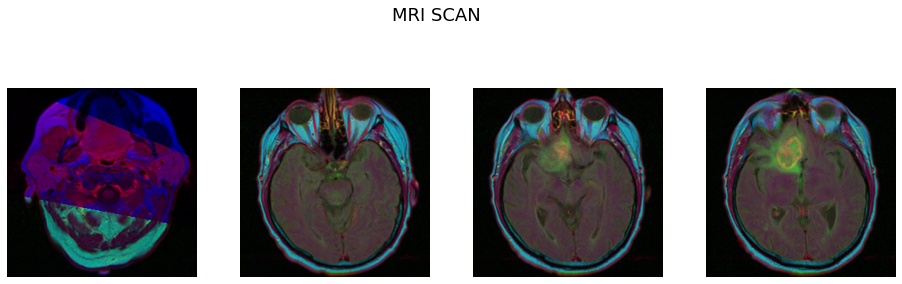

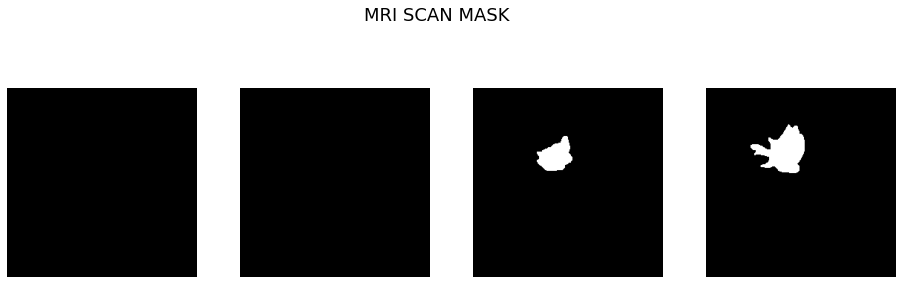

In [6]:
# for image
def visualize_images(data):
    plt.figure(figsize=(16,16))
    plt.suptitle("MRI SCAN",fontsize=18, y=0.95)
    for i,x in enumerate(list(data.keys())[:4]):
        plt.subplot(4,4,i+1)
        plt.axis('off')
        p = cv.imread(x)
        plt.imshow(p)

    plt.show()

    # for mask image
    plt.figure(figsize=(16,16))
    plt.suptitle("MRI SCAN MASK",fontsize=18, y=0.95)
    for i,x in enumerate(list(data.keys())[:4]):
        plt.subplot(4,4,i+1)
        mask = data[x]
        plt.axis('off')
        mask = cv.imread(mask)
        plt.imshow(mask)

    plt.show()
    
visualize_images(data)

In [7]:
dataset["Images"] = list(data.keys())
dataset["Mask"] = list(data.values())
image = dataset.loc[0].Images
img = cv.imread(image)
print("The shape of the image :", img.shape)
mask = dataset.loc[0].Mask
msk = cv.imread(mask)
print("The shape of the mask :",msk.shape)

The shape of the image : (256, 256, 3)
The shape of the mask : (256, 256, 3)


### Train Test Split
<pre>
Train : 80 per
Test/Val  : 20 per

As, dataset is low we won't loss much data for train
</pre>


In [8]:
mask = dataset.Mask.values
train_x,test_x,y_train,y_test = train_test_split(dataset,mask,train_size=0.8,shuffle=True)

In [9]:
print("The train size :",train_x.shape[0])
print("The test size : ",test_x.shape[0])


The train size : 3143
The test size :  786


### Data Preparation
<pre>
Since there are 2 values to predict so our class to predict will be 2.
We will make a mask in such a way that it will be of shape = (256,256,2)
where,

channel one will be only <strong>0</strong>.
channel second will be only <strong>255</strong>.

here zeros represent black and 255 represent white.

also, 
we have only 3143 image so data augmentation will help

</pre>

In [10]:
def preprocess_image(image,mask,h=256,w=256):
    
    '''
    inputs
    
    image --> path of image
    mask --> mask path
    h --> height of the image/mask to resize
    w ---> width of the image/mask to resize
    
    returns :
    
    image ---> normalized image after resizeing
    mask ---> mask with proble class
            
    '''
    labels = [0,255]
    image = cv.imread(image)
    image = cv.resize(image,(h,w),interpolation=cv.INTER_AREA)
    mask = cv.imread(mask,0)
    mask = cv.resize(mask,(h,w),interpolation=cv.INTER_AREA)
    mask_oneHot = [mask==i for i in labels]
    mask = np.stack(mask_oneHot,axis=-1).astype("float64")
    image = image/255
    
    return image,mask 

class datagenerator(tf.keras.utils.Sequence):
    '''
    inputs
    
    image --> all image path
    mask --> all mask path
    h --> height of the image/mask to resize
    w ---> width of the image/mask to resize
    
    output 
    
    will be the generator which load data in batch and send to trining
    
    '''
    
    def __init__(self,datasets,batch,h=256,w=256):
        self.image = datasets.Images.values
        self.mask = datasets.Mask.values
        self.height= h
        self.width = w
        self.batch = batch
        self.indexes = len(datasets)
        
    def __getitem__(self,i):
        
        ## function load imags and corrrespoding mask in batch for trining
        start = i * self.batch
        end = (i+1) * self.batch
        img_batch = []
        msk_batch = []
        for j in range(start,end):
            image,mask = preprocess_image(self.image[j],self.mask[j])
            img_batch.append(image)
            msk_batch.append(mask)
            
        return np.array(img_batch),np.array(msk_batch)
    
    def __len__(self):
        return self.indexes//self.batch
            
    





In [11]:
train_gen= datagenerator(train_x,4) # for train data
test_gen = datagenerator(test_x,4)   # for test data

Shape after batch loading image :  (4, 256, 256, 3)
Shape after batch loading mask : (4, 256, 256, 2)



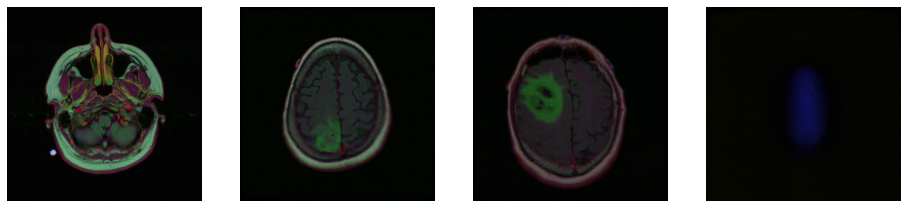

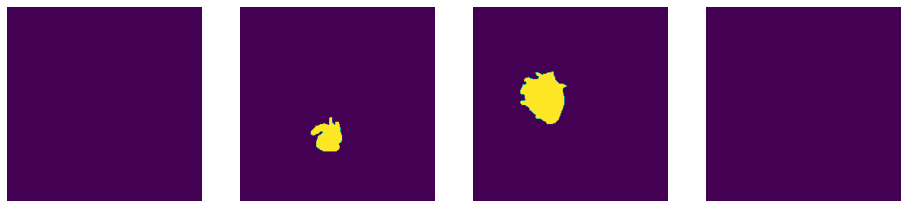

In [12]:
# print(train_x.shape[0])
number = np.random.randint(train_x.shape[0]//4)
train_images , train_mask = train_gen[number]
print("Shape after batch loading image : ",train_images.shape)
print("Shape after batch loading mask :",train_mask.shape)
print()

for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(train_images[i])
    plt.axis("off")
plt.show()

for i in range(4):
    plt.subplot(1,4,i+1)
    mask = np.argmax(train_mask[i],axis=-1)
    plt.imshow(mask)
    plt.axis("off")

    

### Building the Model
<pre>
1. UNET
2. CANET
</pre>

#### UNET

<pre>Since our image shape is (256,256,3) 
and output shape of (256,256,2).

we will develop our model in same way.

</pre>

In [24]:
sm.set_framework('tf.keras')
tf.keras.backend.clear_session()

model_unet = Unet('resnet34', 
                  input_shape = (256,256,3),
                  classes = 2,
                  activation = 'softmax',
                  encoder_weights = 'imagenet',
                  encoder_freeze = True)

model_unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']   

 D)                                                                                               
                                                                                                  
 stage1_unit3_conv1 (Conv2D)    (None, 64, 64, 64)   36864       ['zero_padding2d_6[0][0]']       
                                                                                                  
 stage1_unit3_bn2 (BatchNormali  (None, 64, 64, 64)  256         ['stage1_unit3_conv1[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage1_unit3_relu2 (Activation  (None, 64, 64, 64)  0           ['stage1_unit3_bn2[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padd

                                                                                                  
 stage2_unit3_relu2 (Activation  (None, 32, 32, 128)  0          ['stage2_unit3_bn2[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padding2d_13 (ZeroPadding  (None, 34, 34, 128)  0          ['stage2_unit3_relu2[0][0]']     
 2D)                                                                                              
                                                                                                  
 stage2_unit3_conv2 (Conv2D)    (None, 32, 32, 128)  147456      ['zero_padding2d_13[0][0]']      
                                                                                                  
 add_5 (Add)                    (None, 32, 32, 128)  0           ['stage2_unit3_conv2[0][0]',     
          

                                                                                                  
 stage3_unit2_conv2 (Conv2D)    (None, 16, 16, 256)  589824      ['zero_padding2d_19[0][0]']      
                                                                                                  
 add_8 (Add)                    (None, 16, 16, 256)  0           ['stage3_unit2_conv2[0][0]',     
                                                                  'add_7[0][0]']                  
                                                                                                  
 stage3_unit3_bn1 (BatchNormali  (None, 16, 16, 256)  1024       ['add_8[0][0]']                  
 zation)                                                                                          
                                                                                                  
 stage3_unit3_relu1 (Activation  (None, 16, 16, 256)  0          ['stage3_unit3_bn1[0][0]']       
 )        

                                                                                                  
 stage3_unit6_relu1 (Activation  (None, 16, 16, 256)  0          ['stage3_unit6_bn1[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padding2d_26 (ZeroPadding  (None, 18, 18, 256)  0          ['stage3_unit6_relu1[0][0]']     
 2D)                                                                                              
                                                                                                  
 stage3_unit6_conv1 (Conv2D)    (None, 16, 16, 256)  589824      ['zero_padding2d_26[0][0]']      
                                                                                                  
 stage3_unit6_bn2 (BatchNormali  (None, 16, 16, 256)  1024       ['stage3_unit6_conv1[0][0]']     
 zation)  

                                                                                                  
 stage4_unit3_conv1 (Conv2D)    (None, 8, 8, 512)    2359296     ['zero_padding2d_32[0][0]']      
                                                                                                  
 stage4_unit3_bn2 (BatchNormali  (None, 8, 8, 512)   2048        ['stage4_unit3_conv1[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage4_unit3_relu2 (Activation  (None, 8, 8, 512)   0           ['stage4_unit3_bn2[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padding2d_33 (ZeroPadding  (None, 10, 10, 512)  0          ['stage4_unit3_relu2[0][0]']     
 2D)      

                                                                                                  
 decoder_stage2b_bn (BatchNorma  (None, 64, 64, 64)  256         ['decoder_stage2b_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 decoder_stage2b_relu (Activati  (None, 64, 64, 64)  0           ['decoder_stage2b_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 decoder_stage3_upsampling (UpS  (None, 128, 128, 64  0          ['decoder_stage2b_relu[0][0]']   
 ampling2D)                     )                                                                 
                                                                                                  
 decoder_s

In [93]:
#defining the loss
loss = sm.losses.categorical_focal_dice_loss
#defining the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
#compiling the model
model_unet.compile(optimizer, loss,metrics=[iou_score])

In [ ]:
model_unet.fit(train_gen, 
               validation_data = test_gen, 
               epochs = 1, 
               steps_per_epoch = len(train_gen),
               )

  5/785 [..............................] - ETA: 26:48 - loss: 0.1820 - iou_score: 0.7678

## Testing

<pre>

Epoch 1/5
785/785 [==============================] - 2064s 3s/step - loss: 0.2886 - iou_score: 0.6647 - val_loss: 0.5139 - val_iou_score: 0.4961


Since we have nearly converged with iou score of 0.66 model seem to perform well.

After one epoch 

Train loss = 0.29
Train iou_score = 0.66

Val loss = 0.51
Val iou_score = 0.49
</pre>

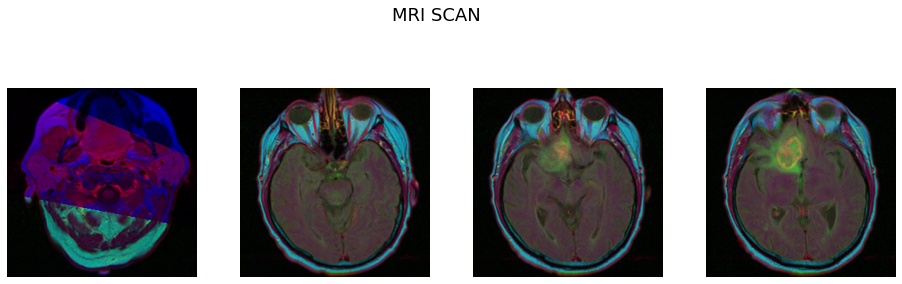

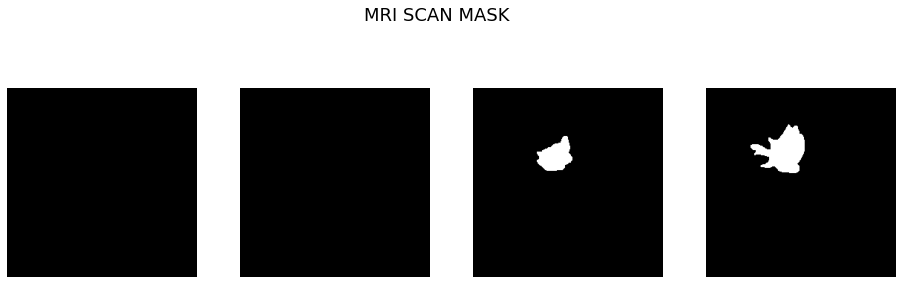

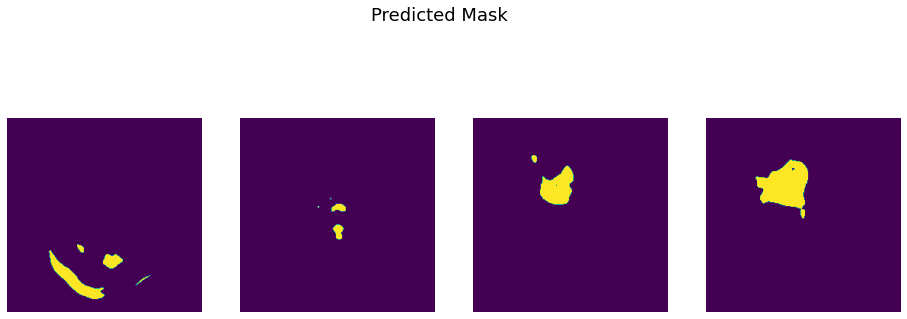

In [95]:
visualize_images(data)
# for predicting images
plt.suptitle("Predicted Mask",fontsize=18, y=0.95)
count =0
for i in list(data.keys())[:4]:
    count +=1
    plt.subplot(3,4,count)
#     plt.figure(figsize=(6,6))
    image = cv.imread(i)
    image = cv.resize(image,(256,256))
    image = image/255
    image = np.expand_dims(image,axis=0)
    mask = model_unet.predict(image)
    mask = np.argmax(mask[0],axis=-1)
    plt.axis("off")
    plt.imshow(mask)
plt.show()
    